# **DEMATEL: Modeling the Factors Influencing the Implementation of Violence Against Women (VAW) Laws in the Philippines Using Fuzzy Multi-Criteria Decision-Making**
**Author**: Daenielle Rai Peladas 
</br>
**Institution**: University of the Philippines - Cebu 
</br>
**Laboratory**: Computational Intelligence and Machine Learning 
</br>
**Advisor**: Associate Professior Dharyll Prince Abellana 
</br>
</br>

**Date Created**: April 13, 2025 
</br>
**Date Modified**: April 13, 2025 
</br>

This Jupyter notebook implements a Fuzzy DEMATEL (Decision Making Trial and Evaluation Laboratory) analysis to identify and quantify the relationships between broad categories affecting the uneven implementation of Violence Against Women (VAW) laws in the Philippines.

The analysis uses expert evaluations from interviews to determine causal relationships between key factors, identifying which are most influential (cause) and which are most affected(effect).

## **Imports and Setup**

In [28]:
# Import library
from pyDEMATEL.FuzzyDEMATELSolver import FuzzyDEMATELSolver 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [29]:
# Import the data
df = pd.read_csv('dematel_data.csv')
df.head()

,Expert,Systemic to Resource,Systemic to Data Monitoring,Systemic to Sociocultural,Systemic to Accessibility,Systemic to Political,Resource to Systemic,Resource to Data Monitoring,Resource to Sociocultural,Resource to Accessibility,...,Accessibility to Systemic,Accessibility to Resource,Accessibility to Data Monitoring,Accessibility to Sociocultural,Accessibility to Political,Political to Systemic,Political to Resource,Political to Data Monitoring,Political to Sociocultural,Political to Accessibility
0,Expert 1,MI,MI,HI,HI,HI,MI,MI,HI,MI,...,MI,HI,MI,HI,HI,HI,HI,HI,MI,HI
1,Expert 2,HI,HI,MI,HI,VHI,VHI,HI,MI,HI,...,HI,HI,HI,MI,HI,HI,VHI,HI,MI,HI
2,Expert 3,MI,HI,HI,HI,MI,HI,LI,LI,LI,...,MI,MI,MI,HI,HI,HI,VHI,LI,HI,MI
3,Expert 4,HI,MI,HI,HI,HI,HI,HI,MI,HI,...,MI,HI,HI,MI,HI,VHI,VHI,HI,HI,HI
4,Expert 5,HI,MI,LI,MI,LI,HI,HI,LI,MI,...,MI,MI,LI,MI,MI,HI,HI,LI,MI,LI


## **Category Definitions**

| Code | Category              | Description                                                                                                                                                                                                                                                                                                                                                                                                              |
|------|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| SYS   | Systemic Weaknesses   | Obstacles embedded in formal processes, policies, and operational structures that hinder effective VAWC implementation, such as a slow justice system causing delayed cases, absence of standardized protocols within help desks, mediation practices, inadequately trained staff, and similar issues.                                                                                                                     |
| RES   | Resource Limitations  | Tangible and intangible assets needed to implement VAWC programs effectively, such as lack of resources within barangay women's desks, underutilization of the GAD budget, lack of financial resources for help desks and service providers, lack of psychosocial programming, and related constraints.                                                                                                                  |
| DAT   | Data Monitoring Challenges | Challenges in collecting, managing, analyzing, and utilizing information related to VAWC cases, such as lack of data harmonization across the interconnected referral system, and inconsistent data collection, reporting, and information sharing practices.                                                                                                                     |
| SOC   | Sociocultural Dynamics| Social norms, cultural beliefs, and community attitudes that shape perceptions and responses to VAWC, such as patriarchal norms and gender biases, social stigma towards victims, underreporting due to a culture of silence, and similar factors.                                                                                                                                                                     |
| ACC   | Accessibility Issues  | Obstacles that prevent victims from seeking help, understanding their rights, or engaging with support services, such as limited access to information about their rights, fear of retaliation from abusers, personal constraints, lack of robust support network, and inaccessibility to services due to poverty.                                                                                                        |
| POL   | Political Factors     | Issues related to the exercise of power, decision-making, political will, and governance that affect VAWC implementation, such as weak enforcement of gender mainstreaming efforts, differing priorities within barangays, weak political commitment to addressing VAW at various government levels, and limited representation of gender equality advocates in leadership positions.                                        |



In [30]:
categories = ["SYS", "RES", "DAT", "SOC", "ACC", "POL"]

In [31]:
num_categories = len(categories)

## **Fuzzy Linguistic Scale**

| Linguistic Terms    | Code | TFN              |
|---------------------|------|------------------|
| No Influence        | NI   | (0.0, 0.1, 0.3)   |
| Low Influence       | LI   | (0.2, 0.3, 0.5)   |
| Medium Influence    | MI   | (0.3, 0.5, 0.7)   |
| High Influence      | HI   | (0.5, 0.7, 0.9)   |
| Very High Influence | VHI  | (0.7, 0.9, 1.0)   |


In [32]:
fuzzy_scale = {
    "NI": (0.0, 0.1, 0.3),
    "LI": (0.2, 0.3, 0.5),
    "MI": (0.3, 0.5, 0.7),
    "HI": (0.5, 0.7, 0.9),
    "VHI": (0.7, 0.9, 1.0)
}

## **Expert Evaluation**

In [33]:
def create_expert_evaluation_matrix(df, expert_id):

    # Extract the values (excluding the 'Expert' column if present)
    values = df.loc[df['Expert'] == expert_id].iloc[0].tolist()
    if isinstance(values[0], str):
        values = values[1:]

    if len(values) != 30:
        raise ValueError(f"Expected 30 values, got {len(values)}")

    matrix = []
    index = 0  # to keep track of position in the 30 values

    for i in range(6):
        row = []
        for j in range(6):
            if i == j:
                row.append((0.0, 0.0, 0.0))
            else:
                row.append(fuzzy_scale[values[index]])
                index += 1
        matrix.append(row)

    return np.array(matrix)


In [34]:
experts = df['Expert'].unique()
experts

array(['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Expert 5',
       'Expert 6', 'Expert 7', 'Expert 8', 'Expert 9'], dtype=object)

In [35]:
num_experts = len(df['Expert'].unique())
num_experts

9

In [38]:
expert_1_matrix = create_expert_evaluation_matrix(df, 'Expert 1')
expert_2_matrix = create_expert_evaluation_matrix(df, 'Expert 2')
expert_3_matrix = create_expert_evaluation_matrix(df, 'Expert 3')
expert_4_matrix = create_expert_evaluation_matrix(df, 'Expert 4')
expert_5_matrix = create_expert_evaluation_matrix(df, 'Expert 5')
expert_6_matrix = create_expert_evaluation_matrix(df, 'Expert 6')
expert_7_matrix = create_expert_evaluation_matrix(df, 'Expert 7')
expert_8_matrix = create_expert_evaluation_matrix(df, 'Expert 8')
expert_9_matrix = create_expert_evaluation_matrix(df, 'Expert 9')

### Combination of All Experts

In [39]:
all_expert_evals = np.array([expert_1_matrix, expert_2_matrix, expert_3_matrix, expert_4_matrix, expert_5_matrix, expert_6_matrix, expert_7_matrix, expert_8_matrix, expert_9_matrix])

## **Fuzzy DEMATEL Implementation**

In [40]:
# Initialize solver
solver = FuzzyDEMATELSolver()
solver.setMatrix(all_expert_evals)

In [41]:
# Add experts and categorical factor information
for expert in experts:
    solver.addExpert(expert)

solver.setFactors(categories)
solver.setNumberOfExperts(num_experts)
solver.setNumberOfFactors(num_categories)

In [42]:
# Execute the DEMATEL steps 
print("\nExecuting Fuzzy DEMATEL analysis...")

solver.step1()
print("\u2714 Step 1: Direct Influence Fuzzy Matrix created.")

solver.step2()
print("\u2714 Step 2: Normalized Direct Influence Fuzzy Matrix created.")

solver.step3()
print("\u2714 Step 3: Total Influence Fuzzy Matrix created.")

solver.step4()
print("\u2714 Step 4: Prominence and Relation calculated.")


Executing Fuzzy DEMATEL analysis...
✔ Step 1: Direct Influence Fuzzy Matrix created.
✔ Step 2: Normalized Direct Influence Fuzzy Matrix created.
✔ Step 3: Total Influence Fuzzy Matrix created.
✔ Step 4: Prominence and Relation calculated.


## **Results Analysis**

In [43]:
# Get results 
prominence = solver.getProminence()
relation = solver.getRalation()

# Create DataFrame 
results_df = pd.DataFrame({
    'Factor': categories,
    'Prominence (R+C)': prominence,
    'Relation (R-C)': relation
})

In [44]:
# Sort by prominence to identify the most important factors
results_df_sorted = results_df.sort_values('Prominence (R+C)', ascending = False)
print(results_df_sorted)

  Factor  Prominence (R+C)  Relation (R-C)
5    POL         15.059169        0.111079
4    ACC         14.902363       -0.003713
1    RES         14.886550       -0.541541
0    SYS         14.756383       -0.172134
3    SOC         14.252699        0.535262
2    DAT         14.185969        0.071046


In [45]:
# Identify cause and effect groups 
causes = results_df[results_df['Relation (R-C)'] > 0].sort_values('Relation (R-C)', ascending=False)
effects = results_df[results_df['Relation (R-C)'] <= 0].sort_values('Relation (R-C)', ascending=True)

print("\nCause Group (Positive R-C)")
print(causes)

print("\nEffect Group (Negative R-C)")
print(effects)


Cause Group (Positive R-C)
  Factor  Prominence (R+C)  Relation (R-C)
3    SOC         14.252699        0.535262
5    POL         15.059169        0.111079
2    DAT         14.185969        0.071046

Effect Group (Negative R-C)
  Factor  Prominence (R+C)  Relation (R-C)
1    RES         14.886550       -0.541541
0    SYS         14.756383       -0.172134
4    ACC         14.902363       -0.003713


## **Visualization**

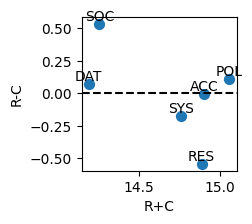

In [46]:
solver.drawCurve()

### Causal Diagram

In [47]:
def create_causal_diagram(relation, prominence, categories, title='Causal Diagram of VAW Law Implementation Factors'):
    """
    Create a causal diagram scatter plot from DEMATEL results.
    
    Parameters:
    - relation: Array of R-C values (causal effect)
    - prominence: Array of R+C values (importance)
    - categories: List of factor names/labels
    - title: Title for the plot (optional)
    
    Returns:
    - fig, ax: The matplotlib figure and axis objects
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create scatter plot
    ax.scatter(relation, prominence, s=100)
    
    # Add labels for each point
    for i, factor in enumerate(categories):
        ax.annotate(factor, (relation[i], prominence[i]),
                   textcoords="offset points",
                   xytext=(0, 10),
                   ha='center')
    
    # Add quadrant dividers
    ax.axhline(y=np.mean(prominence), color='gray', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    # Label quadrants
    ax.text(max(relation)*0.75, max(prominence)*0.9, "Core Causes",
           ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    ax.text(min(relation)*0.75, max(prominence)*0.9, "Core Effects",
           ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    # Set labels and title
    ax.set_xlabel('Relation (R-C)')
    ax.set_ylabel('Prominence (R+C)')
    ax.set_title(title)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

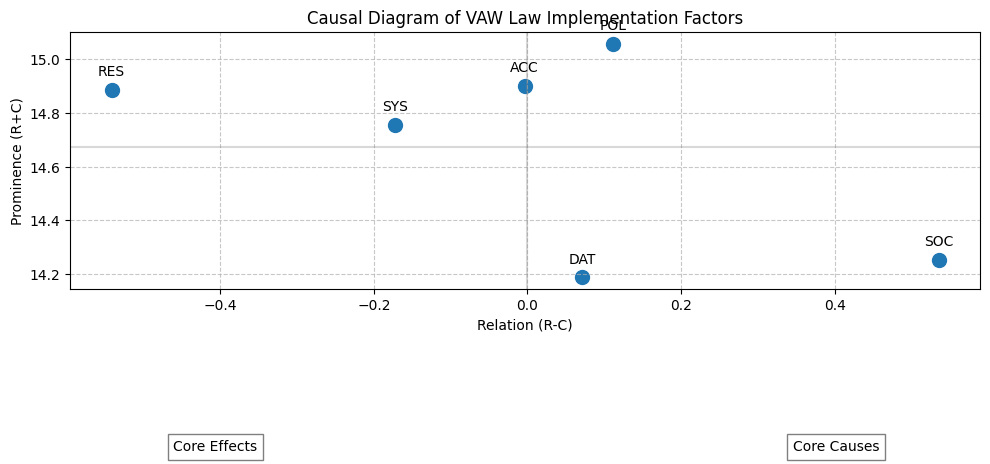

In [48]:
fig1, ax1 = create_causal_diagram(relation, prominence, categories, 
                                 title="Causal Diagram of VAW Law Implementation Factors")
plt.savefig('causal_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

### Diagraph

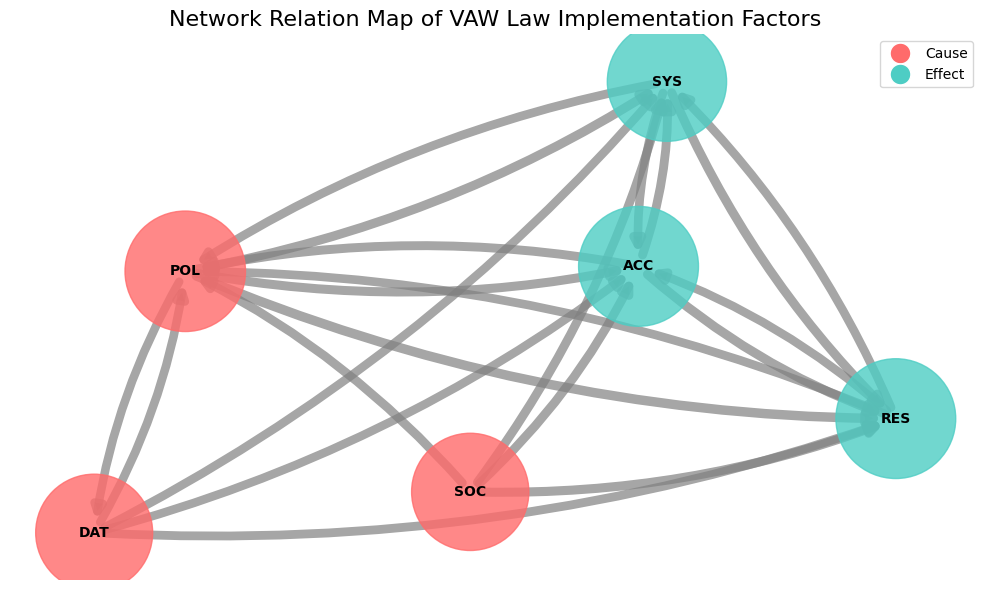

In [49]:
def create_network_relation_map(solver, factors, threshold=None):
    """
    Create a network relation map (digraph) from fuzzy DEMATEL results.
    
    Parameters:
    - solver: The FuzzyDEMATELSolver object after running all steps
    - factors: List of factor names
    - threshold: Optional threshold value to show only significant relationships
                 If None, uses the average of total influence matrix values
    
    Returns:
    - fig, ax: The matplotlib figure and axis objects
    """

    # Get the defuzzified total influence matrix
    total_influence_matrix = solver.getFuzzyTotalInfluenceMatrix()
    
    # Assuming we need to defuzzify (adjust this based on your actual implementation)
    defuzzified_matrix = np.zeros((len(factors), len(factors)))
    for i in range(len(factors)):
        for j in range(len(factors)):
            # Defuzzify by taking the average of the triangle's vertices
            # This is a simple defuzzification method; adjust as needed
            l, m, u = total_influence_matrix[i][j]
            defuzzified_matrix[i][j] = (l + m + u) / 3
    
    # Set threshold if not provided
    if threshold is None:
        threshold = np.mean(defuzzified_matrix)
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    prominence = solver.getProminence()
    relation = solver.getRalation() 
    
    for i, factor in enumerate(factors):
        # Add node with attributes
        G.add_node(factor, 
                  prominence=prominence[i], 
                  relation=relation[i],
                  is_cause=(relation[i] > 0))
    
    # Add edges for relationships above threshold
    for i in range(len(factors)):
        for j in range(len(factors)):
            if i != j and defuzzified_matrix[i][j] > threshold:
                G.add_edge(factors[i], factors[j], 
                           weight=defuzzified_matrix[i][j],
                           width=defuzzified_matrix[i][j] * 5)  # Scale width for visibility
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define node colors based on cause/effect
    node_colors = ['#FF6B6B' if G.nodes[node]['is_cause'] else '#4ECDC4' for node in G.nodes()]
    
    # Node size based on prominence
    node_sizes = [G.nodes[node]['prominence'] * 500 for node in G.nodes()]
    
    # Position nodes using a spring layout
    # You might need to adjust k (the optimal distance) based on your graph
    pos = nx.spring_layout(G, k=0.4, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes, 
                          node_color=node_colors, 
                          alpha=0.8,
                          ax=ax)
    
    # Draw edges with varying thickness based on weight
    edge_widths = [G[u][v]['width'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, 
                          width=edge_widths, 
                          alpha=0.7, 
                          edge_color='gray',
                          connectionstyle='arc3,rad=0.1',  # Curved edges
                          arrowsize=15,
                          ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
    
    # Add legend
    cause_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', 
                            markersize=15, label='Cause')
    effect_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', 
                             markersize=15, label='Effect')
    plt.legend(handles=[cause_patch, effect_patch], loc='upper right')
    
    # Add title and clean up plot
    plt.title('Network Relation Map of VAW Law Implementation Factors', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    return fig, ax

# After running all DEMATEL steps, call this function:
fig, ax = create_network_relation_map(solver, categories)
plt.savefig('network_relation_map.png', dpi=300, bbox_inches='tight')
plt.show()

## **Save Results**

In [50]:
path = "/home/rai/thesis"
solver.savexl(path)

Excel file successfully created.


## **Conclusion**

Based on the Fuzzy DEMATEL analysis, the following insights were obtained:

In [51]:
# Sort factors by prominence
most_prominent = results_df_sorted.iloc[0]['Factor']
print(f"1. Most influential factor overall: {most_prominent}")

1. Most influential factor overall: POL


In [52]:
# Identify strongest cause
strongest_cause = causes.iloc[0]['Factor']
print(f"2. Strongest cause factor: {strongest_cause}")

2. Strongest cause factor: SOC


In [53]:
# Identify most affected
most_affected = effects.iloc[0]['Factor']
print(f"3. Most affected factor: {most_affected}")

3. Most affected factor: RES


These findings suggest that policies addressing VAW implementation should prioritize addressing the causal factors to achieve maximum impact.